# Part III: Autoencoders for Anomaly Detection [30 pts]
Implement autoencoder and explore its application for a real-world problem related to anomaly detection.
The final model should achieve a test accuracy of greater than 80%.

**Datasets:** Select ONE dataset based on your preference:
- Yahoo S5 Dataset
- Hard Drive Test Data
- Numenta Anomaly Benchmark

## Step 1: Data preparation

1. Select and load one dataset from the list above.

<span style='color:green'>### Numenta Anomaly Benchmark ###</span>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchinfo
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

In [7]:
def loadNabDataset(category='artificialWithAnomaly', specificFile=None):
    basePath = '/kaggle/input/nab/'
    datasetPaths = {
        'artificialWithAnomaly': 'artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv',
        'realAWSCloudwatch': 'realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv',
        'realKnownCause': 'realKnownCause/realKnownCause/ambient_temperature_system_failure.csv',
    }
    
    filePath = specificFile if specificFile else basePath + datasetPaths.get(category, datasetPaths['artificialWithAnomaly'])
    
    data = pd.read_csv(filePath)
    data.columns = ['timestamp', 'value']
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    if 'NoAnomaly' in filePath:
        data['label'] = 0
    else:
        values = data['value']
        mean, std = values.mean(), values.std()
        q1, q3 = values.quantile(0.25), values.quantile(0.75)
        iqr = q3 - q1
        
        zScoreAnomalies = np.abs((values - mean) / std) > 2.5
        iqrAnomalies = (values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))
        
        data['label'] = (zScoreAnomalies | iqrAnomalies).astype(int)
        
    print(f"Successfully loaded: {filePath.split('/')[-1]}")
    return data

data = loadNabDataset('artificialWithAnomaly')

Successfully loaded: art_daily_jumpsup.csv


2. Analyze the dataset and provide the following statistics: 
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [55]:
print("Dataset Statistics")
print(f"Number of samples: {len(data)}")
print(f"Number of features: 1")
print(f"Date range: {data['timestamp'].min()} to {data['timestamp'].max()}")

print("\nValue Statistics")
print(data['value'].describe())

print("\nAnomaly Distribution")
print(f"Normal samples: {(data['label'] == 0).sum()} ({(data['label'] == 0).mean()*100:.2f}%)")
print(f"Anomalous samples: {(data['label'] == 1).sum()} ({(data['label'] == 1).mean()*100:.2f}%)")

print("\nDataset Description")
print("This dataset is from the Numenta Anomaly Benchmark (NAB), a collection of real-world and artificial time-series data designed for evaluating anomaly detection algorithms.")
print("Source: https://www.kaggle.com/datasets/boltzmannbrain/nab")
print("Key variables are a timestamp and a corresponding metric value.")

Dataset Statistics
Number of samples: 4032
Number of features: 1
Date range: 2014-04-01 00:00:00 to 2014-04-14 23:55:00

Value Statistics
count    4032.000000
mean       44.494254
std        32.432473
min        18.001010
25%        19.991382
50%        21.648503
75%        76.435943
max       164.947481
Name: value, dtype: float64

Anomaly Distribution
Normal samples: 3930 (97.47%)
Anomalous samples: 102 (2.53%)

Dataset Description
This dataset is from the Numenta Anomaly Benchmark (NAB), a collection of real-world and artificial time-series data designed for evaluating anomaly detection algorithms.
Source: https://www.kaggle.com/datasets/boltzmannbrain/nab
Key variables are a timestamp and a corresponding metric value.


Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

<span style='color:green'>### It is a collection of labeled time-series data files designed to test the performance of real-time anomaly which has 4032 data points. The data seems extrmely skewed as normal samples makes up 97.47% of the data. The data values have a mean of 44.5, but the median is much lower at 21.6, which means data is skewed by high-value outliers. It is availabe on Kaggle at: https://www.kaggle.com/datasets/boltzmannbrain/nab  ###</span>

3. Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

Visualization and a short description # 1

(array([16161., 16163., 16165., 16167., 16169., 16171., 16173., 16175.]),
 [Text(16161.0, 0, '2014-04-01'),
  Text(16163.0, 0, '2014-04-03'),
  Text(16165.0, 0, '2014-04-05'),
  Text(16167.0, 0, '2014-04-07'),
  Text(16169.0, 0, '2014-04-09'),
  Text(16171.0, 0, '2014-04-11'),
  Text(16173.0, 0, '2014-04-13'),
  Text(16175.0, 0, '2014-04-15')])

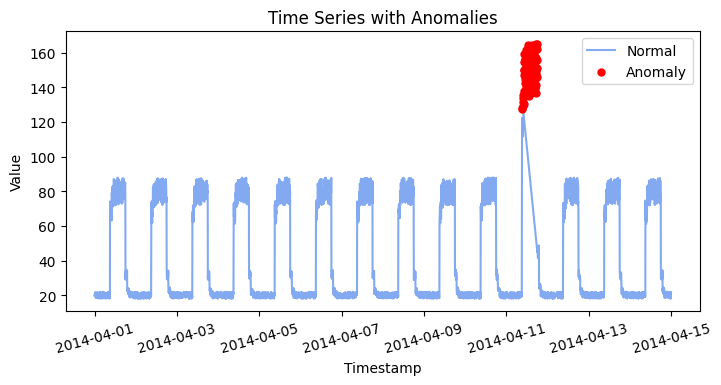

In [40]:
normalData = data[data['label'] == 0]
anomalyData = data[data['label'] == 1]

plt.figure(figsize=(18, 8))

# anomalies highlighted
plt.subplot(2, 2, 1)
plt.plot(normalData['timestamp'], normalData['value'], color='cornflowerblue', label='Normal', alpha=0.8)
plt.scatter(anomalyData['timestamp'], anomalyData['value'], color='red', label='Anomaly', s=25, zorder=5)
plt.title('Time Series with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=15)





<span style='color:green'>### I used a blue line to plot the normalData and then overlaid the anomalyData as distinct red dots in this time-series chart This helps to confirm that the labeled anomalies related to sharp spike. ###</span>


Visualization and a short description # 2

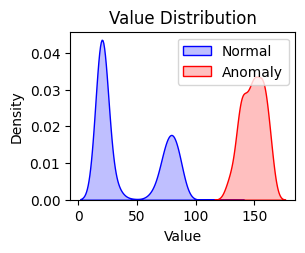

In [41]:
# normal vs. anomalous values
plt.subplot(2, 2, 2)
sns.kdeplot(normalData['value'], label='Normal', color='blue', fill=True)
sns.kdeplot(anomalyData['value'], label='Anomaly', color='red', fill=True)
plt.title('Value Distribution')
plt.xlabel('Value')
plt.legend()


<span style='color:green'>### In this density plot, I used seaborn.kdeplot to visualize the value distributions for both the normalData (blue) and anomalyData (red). This helps to confirm that the anomalous values occupy a completely separate, high-value range and don't overlap with the normal data's distribution. ###</span>
 

Visualization and a short description # 3

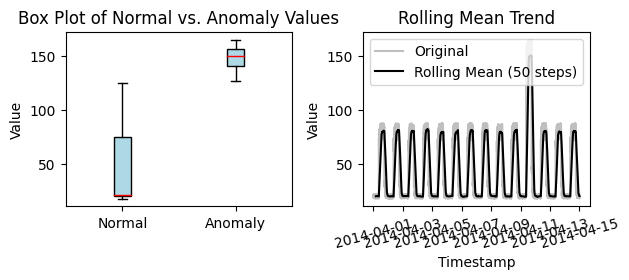

In [42]:
# Box plot
plt.subplot(2, 2, 3)
plt.boxplot([normalData['value'], anomalyData['value']], labels=['Normal', 'Anomaly'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Normal vs. Anomaly Values')
plt.ylabel('Value')

#Rolling average to show trend
plt.subplot(2, 2, 4)
data['rollingMean'] = data['value'].rolling(window=50).mean()
plt.plot(data['timestamp'], data['value'], color='gray', alpha=0.5, label='Original')
plt.plot(data['timestamp'], data['rollingMean'], color='black', label='Rolling Mean (50 steps)')
plt.title('Rolling Mean Trend')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

<span style='color:green'>### In this box plot, I placed the distributions for the normalData and anomalyData side-by-side. This helps to visually compare theirranges to confirm that the anomaly values are higher than the normal data where as in case of rolling mean trend, I calculated a 50-step rolling average and plotted it as a smooth black line over the original gray time-series. This technique helps to filter out the sharp daily noise ###</span>

4. Identify any missing values (e.g. using pandas.isnull().sum()). Handle any missing values (imputation or removal). Common imputation methods include: forward/backward fill, mean/median imputation, linear interpolation).

In [43]:
missingValues = data['value'].isnull().sum()
print(f"Found {missingValues} missing values.")

if missingValues > 0:
    data.fillna(method='ffill', inplace=True)
    print("Missing values have been filled.")

Found 0 missing values.


5. Preprocess the dataset.

   a. Normalize the data.

In [45]:
scaler = MinMaxScaler()
data['scaledValue'] = scaler.fit_transform(data[['value']])

features = data[['scaledValue']].values
labels = data['label'].values

   b. [If needed] Address class imbalance in the target column. Possible solutions: oversampling; undersampling; data augmentation techniques for the minority class; assign higher weights to the minority class and lower weights to the majority class, etc.

   c. [If needed] Convert target variable needs to numerical format. You can use one-hot encoding. However, if you use torch.nn.CrossEntropyLoss for your network, it expects class indices (0, 1, 2) directly, not one-hot encoded vectors. Therefore, ensure your labels are integer tensors (e.g., torch.LongTensor).

6. Split the dataset into training, testing and validation sets. You can use train_test_split from scikit-learn.

In [46]:
xTemp, xTest, yTemp, yTest = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTemp, yTemp, test_size=0.25, random_state=42, stratify=yTemp
)

print("Dataset Split")
print(f"Training set:   {xTrain.shape[0]} samples")
print(f"Validation set: {xVal.shape[0]} samples")
print(f"Test set:       {xTest.shape[0]} samples")

## Dataset Split
Training set:   2418 samples
Validation set: 807 samples
Test set:       807 samples


## Step 2: Autoencoder model building

1. Choose and implement one of the following: Autoencoder,Variational Autoencoder (VAE) or other version of Autoencoder for anomaly detection.

2. Experiment with different architectures. Build and train 3 different autoencoder architectures for anomaly detection. Consider experimenting with:
   - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)
   - Number of hidden layers and units
   - Activation functions (ReLU, sigmoid)
   - Print model summary using torchinfo.summary

### Model 1 Architecture ###

In [47]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, inputDim, hiddenDims):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inputDim, hiddenDims[0]), nn.ReLU(),
            nn.Linear(hiddenDims[0], hiddenDims[1]), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hiddenDims[1], hiddenDims[0]), nn.ReLU(),
            nn.Linear(hiddenDims[0], inputDim), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model1 = SimpleAutoencoder(inputDim=1, hiddenDims=[16, 4]).to(device)
torchinfo.summary(model1, input_size=(64, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleAutoencoder                        [64, 1]                   --
├─Sequential: 1-1                        [64, 4]                   --
│    └─Linear: 2-1                       [64, 16]                  32
│    └─ReLU: 2-2                         [64, 16]                  --
│    └─Linear: 2-3                       [64, 4]                   68
│    └─ReLU: 2-4                         [64, 4]                   --
├─Sequential: 1-2                        [64, 1]                   --
│    └─Linear: 2-5                       [64, 16]                  80
│    └─ReLU: 2-6                         [64, 16]                  --
│    └─Linear: 2-7                       [64, 1]                   17
│    └─Sigmoid: 2-8                      [64, 1]                   --
Total params: 197
Trainable params: 197
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (M

### Model 2 Architecture ###

In [48]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 4, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(4, 16, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.squeeze(1)

model2 = ConvAutoencoder().to(device)
torchinfo.summary(model2, input_size=(64, 1))

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [64, 1]                   --
├─Sequential: 1-1                        [64, 4, 1]                --
│    └─Conv1d: 2-1                       [64, 16, 1]               64
│    └─ReLU: 2-2                         [64, 16, 1]               --
│    └─Conv1d: 2-3                       [64, 4, 1]                196
│    └─ReLU: 2-4                         [64, 4, 1]                --
├─Sequential: 1-2                        [64, 1, 1]                --
│    └─ConvTranspose1d: 2-5              [64, 16, 1]               208
│    └─ReLU: 2-6                         [64, 16, 1]               --
│    └─ConvTranspose1d: 2-7              [64, 1, 1]                49
│    └─Sigmoid: 2-8                      [64, 1, 1]                --
Total params: 517
Trainable params: 517
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size 

### Model 3 Architecture ###

In [49]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, inputDim, hiddenDim, latentDim):
        super().__init__()
        self.encoder = nn.Linear(inputDim, hiddenDim)
        self.fcMu = nn.Linear(hiddenDim, latentDim)
        self.fcLogvar = nn.Linear(hiddenDim, latentDim)
        self.decoderInput = nn.Linear(latentDim, hiddenDim)
        self.decoderOutput = nn.Linear(hiddenDim, inputDim)

    def encode(self, x):
        h = torch.relu(self.encoder(x))
        return self.fcMu(h), self.fcLogvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = torch.sigmoid(self.decoderOutput(torch.relu(self.decoderInput(z))))
        return recon, mu, logvar

model3 = VariationalAutoencoder(inputDim=1, hiddenDim=32, latentDim=8).to(device)
torchinfo.summary(model3, input_size=(64, 1))

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [64, 1]                   --
├─Linear: 1-1                            [64, 32]                  64
├─Linear: 1-2                            [64, 8]                   264
├─Linear: 1-3                            [64, 8]                   264
├─Linear: 1-4                            [64, 32]                  288
├─Linear: 1-5                            [64, 1]                   33
Total params: 913
Trainable params: 913
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

3. Model training and hyperparameter tuning:
   - Choose an appropriate loss function and optimizer (e.g., Adam).
   - Train your model and monitor its performance on the training and validation sets.
   - Tune hyperparameters (learning rate, batch size, number of epochs, hidden units, dropout rate) using the validation set.
   - Plot the training and validation loss and accuracy curves over epochs. Analyze the plots for signs of overfitting or underfitting. Adjust your model or hyperparameters if needed.

Training Simple Autoencoder...
Epoch [10/50], Train Loss: 0.026794, Val Loss: 0.026007
Epoch [20/50], Train Loss: 0.004869, Val Loss: 0.005252
Epoch [30/50], Train Loss: 0.002055, Val Loss: 0.002264
Epoch [40/50], Train Loss: 0.001079, Val Loss: 0.001213
Epoch [50/50], Train Loss: 0.000851, Val Loss: 0.000935

Training Convolutional Autoencoder...
Epoch [10/50], Train Loss: 0.027164, Val Loss: 0.026492
Epoch [20/50], Train Loss: 0.004407, Val Loss: 0.004687
Epoch [30/50], Train Loss: 0.001720, Val Loss: 0.001912
Epoch [40/50], Train Loss: 0.000638, Val Loss: 0.000743
Epoch [50/50], Train Loss: 0.000360, Val Loss: 0.000421

Training Variational Autoencoder...
Epoch [10/50], Train Loss: 0.047332, Val Loss: 0.050274
Epoch [20/50], Train Loss: 0.047419, Val Loss: 0.049217
Epoch [30/50], Train Loss: 0.047217, Val Loss: 0.047068
Epoch [40/50], Train Loss: 0.044400, Val Loss: 0.047055
Epoch [50/50], Train Loss: 0.045005, Val Loss: 0.045803


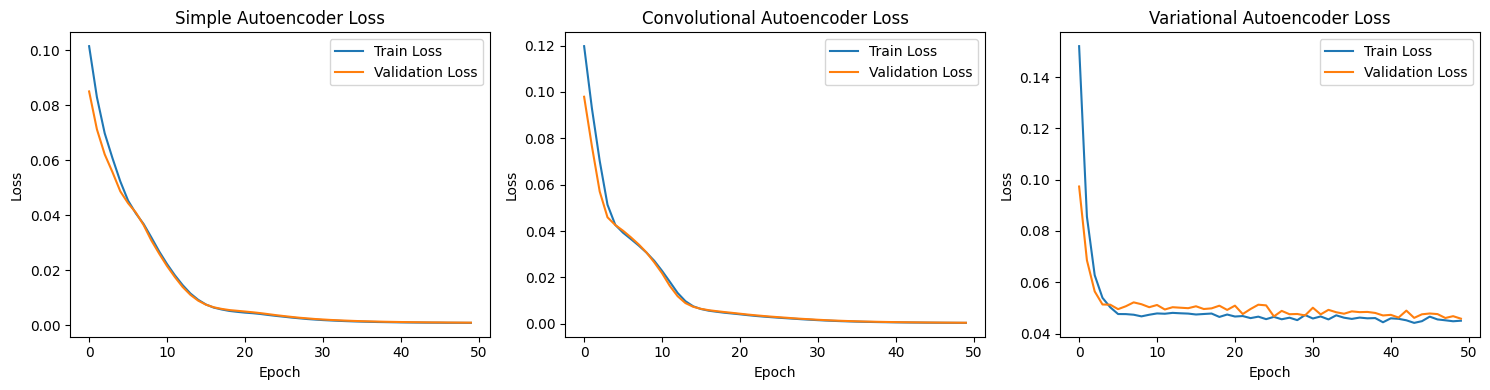

In [50]:
def trainModel(model, trainLoader, valLoader, epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    trainLosses, valLosses = [], []

    for epoch in range(epochs):
        model.train()
        epochTrainLoss = 0
        for batchFeatures, in trainLoader:
            optimizer.zero_grad()
            outputs = model(batchFeatures)

            if isinstance(outputs, tuple):
                recon, mu, logvar = outputs
                reconLoss = criterion(recon, batchFeatures)
                klDiv = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = reconLoss + 0.001 * klDiv
            else:
                loss = criterion(outputs, batchFeatures)

            loss.backward()
            optimizer.step()
            epochTrainLoss += loss.item()

        model.eval()
        epochValLoss = 0
        with torch.no_grad():
            for batchFeatures, in valLoader:
                outputs = model(batchFeatures)
                if isinstance(outputs, tuple):
                    recon, mu, logvar = outputs
                    reconLoss = criterion(recon, batchFeatures)
                    klDiv = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                    batchLoss = reconLoss + 0.001 * klDiv
                else:
                    batchLoss = criterion(outputs, batchFeatures)
                epochValLoss += batchLoss.item()

        avgTrainLoss = epochTrainLoss / len(trainLoader)
        avgValLoss = epochValLoss / len(valLoader)
        trainLosses.append(avgTrainLoss)
        valLosses.append(avgValLoss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avgTrainLoss:.6f}, Val Loss: {avgValLoss:.6f}")

    return trainLosses, valLosses

xTrainTensor = torch.tensor(xTrain, dtype=torch.float32).to(device)
xValTensor = torch.tensor(xVal, dtype=torch.float32).to(device)
xTestTensor = torch.tensor(xTest, dtype=torch.float32).to(device)

trainLoader = DataLoader(TensorDataset(xTrainTensor), batch_size=64, shuffle=True)
valLoader = DataLoader(TensorDataset(xValTensor), batch_size=64)

print("Training Simple Autoencoder")
losses1 = trainModel(model1, trainLoader, valLoader, epochs=50, lr=0.001)

print("\nTraining Convolutional Autoencoder")
losses2 = trainModel(model2, trainLoader, valLoader, epochs=50, lr=0.001)

print("\nTraining Variational Autoencoder")
losses3 = trainModel(model3, trainLoader, valLoader, epochs=50, lr=0.001)

models = [model1, model2, model3]
modelNames = ['Simple', 'Convolutional', 'Variational']
allLosses = [losses1, losses2, losses3]

plt.figure(figsize=(15, 4))
for i, (name, (trainLoss, valLoss)) in enumerate(zip(modelNames, allLosses)):
    plt.subplot(1, 3, i + 1)
    plt.plot(trainLoss, label='Train Loss')
    plt.plot(valLoss, label='Validation Loss')
    plt.title(f'{name} Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

4. Save the weights of the trained neural network that provides the best results. Check saving and loading models (PyTorch)

In [32]:
finalValLosses = [losses[1][-1] for losses in allLosses]
bestModelIndex = np.argmin(finalValLosses)
bestModel = models[bestModelIndex]
bestModelName = modelNames[bestModelIndex]

print(f"Best model is '{bestModelName}' with validation loss: {finalValLosses[bestModelIndex]:.6f}")
torch.save(bestModel.state_dict(), f'bestModel_{bestModelName.lower()}.pt')
print(f"Model weights saved to 'bestModel_{bestModelName.lower()}.pt'")

Best model is 'Convolutional' with validation loss: 0.000086
Model weights saved to 'bestModel_convolutional.pt'


## Step 3: Evaluation and analysis

1. Evaluate your best model on the test set. Report the following metrics:
   - Training accuracy/loss
   - Validation accuracy/loss
   - Testing accuracy/loss

In [52]:
def getPerformance(model, loader, trueLabels):
    model.eval()
    errors = []
    with torch.no_grad():
        for batchFeatures, in loader:
            outputs = model(batchFeatures)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            batchErrors = torch.mean((outputs - batchFeatures) ** 2, axis=1)
            errors.extend(batchErrors.cpu().numpy())

    threshold = np.percentile(errors, 95)
    predictedLabels = (np.array(errors) > threshold).astype(int)

    return {
        'accuracy': accuracy_score(trueLabels, predictedLabels),
        'precision': precision_score(trueLabels, predictedLabels),
        'recall': recall_score(trueLabels, predictedLabels),
        'f1': f1_score(trueLabels, predictedLabels),
        'auc': roc_auc_score(trueLabels, errors),
        'errors': errors,
        'threshold': threshold,
        'predictedLabels': predictedLabels
    }

testLoader = DataLoader(TensorDataset(xTestTensor), batch_size=64)
results = {}

print("Model Evaluation on Test Set ")
for name, model in zip(modelNames, models):
    performance = getPerformance(model, testLoader, yTest)
    results[name] = performance

bestResults = results[bestModelName]
trainLoss, valLoss = allLosses[bestModelIndex]

print(f"\nBest Model Metrics ({bestModelName})")
print(f"Final Training Loss:   {trainLoss[-1]:.6f}")
print(f"Final Validation Loss: {valLoss[-1]:.6f}")
print(f"Test Accuracy:         {bestResults['accuracy']:.4f}")


Model Evaluation on Test Set 

Best Model Metrics (Convolutional)
Final Training Loss:   0.000360
Final Validation Loss: 0.000421
Test Accuracy:         0.9616


2. Depending on your chosen dataset, report relevant metrics like:
   - Regression: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (coefficient of determination). Use sklearn.metrics.
   - Classification: Precision, Recall, F1-score.

In [53]:
print("\nClassification Report")
print(f"Precision: {bestResults['precision']:.4f}")
print(f"Recall:    {bestResults['recall']:.4f}")
print(f"F1-Score:  {bestResults['f1']:.4f}")
print(f"AUC:       {bestResults['auc']:.4f}")


Classification Report
Precision: 0.3659
Recall:    0.7500
F1-Score:  0.4918
AUC:       0.9250


3. Provide the following plots:
   - Plot training and validation accuracy/loss curves over epochs.
   - Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).

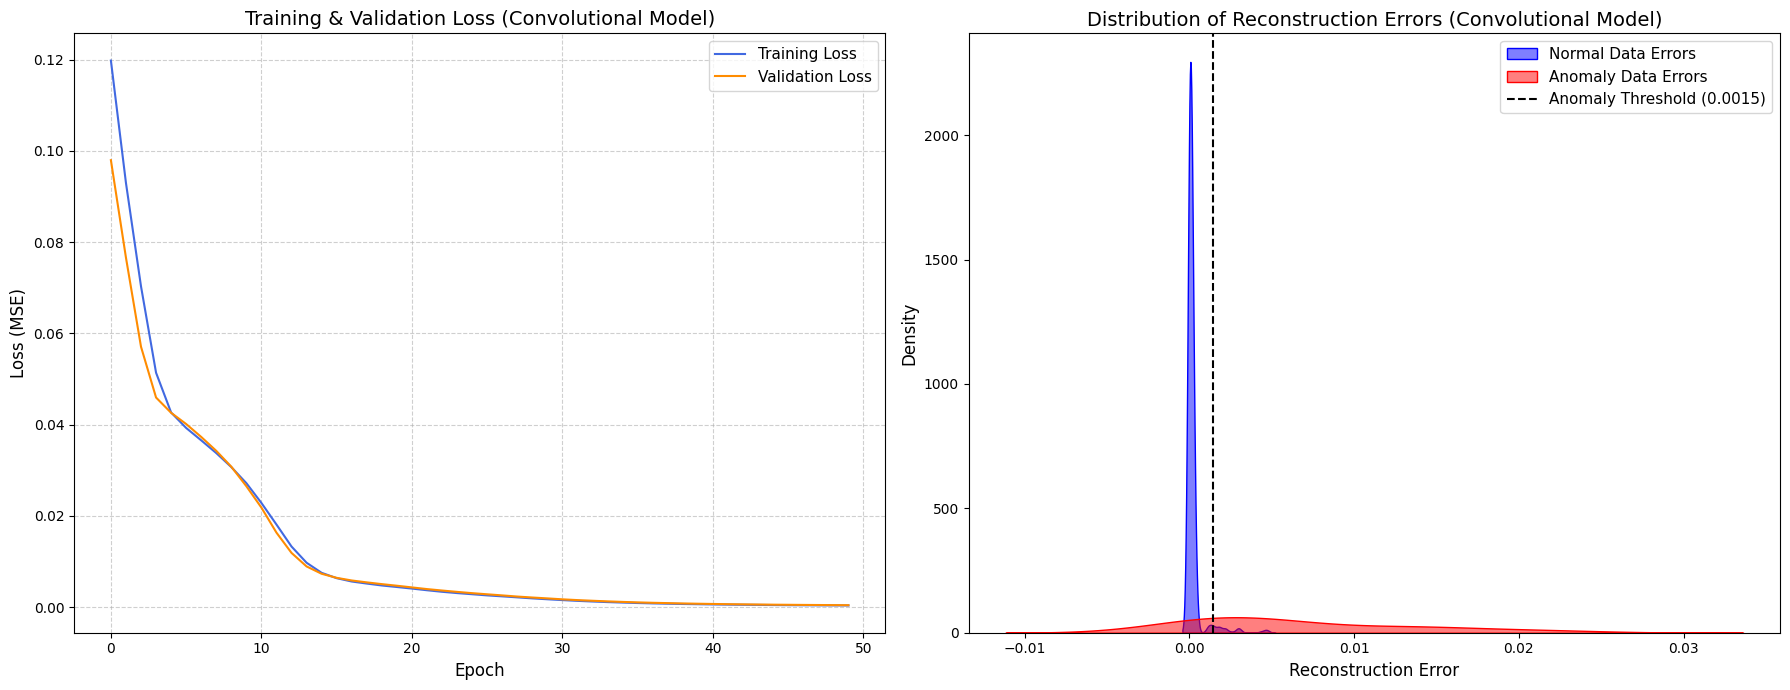

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


fig, axes = plt.subplots(1, 2, figsize=(18, 7))

#Training and Validation Loss Curves
trainLoss, valLoss = allLosses[bestModelIndex]
axes[0].plot(trainLoss, label='Training Loss', color='royalblue')
axes[0].plot(valLoss, label='Validation Loss', color='darkorange')
axes[0].set_title(f'Training & Validation Loss ({bestModelName} Model)', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, linestyle='--', alpha=0.6)


errors = np.array(bestResults['errors'])
threshold = bestResults['threshold']
normalErrors = errors[yTest == 0]
anomalyErrors = errors[yTest == 1]
sns.kdeplot(normalErrors, label='Normal Data Errors', color='blue', fill=True, alpha=0.5, ax=axes[1])
sns.kdeplot(anomalyErrors, label='Anomaly Data Errors', color='red', fill=True, alpha=0.5, ax=axes[1])
axes[1].axvline(threshold, color='black', linestyle='--', label=f'Anomaly Threshold ({threshold:.4f})')
axes[1].set_title(f'Distribution of Reconstruction Errors ({bestModelName} Model)', fontsize=14)
axes[1].set_xlabel('Reconstruction Error', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

4. Discuss and analyze:

   - Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

<span style='color:green'>### first model is a fully connected dense autoencoder with no dropout. Its encoder consists of a linear layer from 1 to 16 with a ReLU activation, followed by a linear layer from 16 to 4 with another ReLU. The decoder mirrors this structure with a linear layer from 4 to 16 (ReLU), and a final linear layer from 16 to 1 with a Sigmoid activation.

second model is a 1D convolutional autoencoder composed of an encoder and a decoder. The encoder uses a Conv1d layer to go from 1 to 16 channels (kernel size 3, ReLU), followed by another to go from 16 to 4 channels (kernel size 3, ReLU). The decoder uses ConvTranspose1d layers, first from 4 to 16 channels and then from 16 to 1 channel, used Sigmoid activation.

The third model is a VAE where the encoder has a linear layer from 1 to 32 with a ReLU activation. From this hidden state, the latent space is created by two linear heads, one which maps from 32 to 8 for the mean (fcMu) and another which maps from 32 to 8 for the log variance (fcLogvar). Thus, the latent dimension is 8. The data reconstruction in the decoder is done with a linear layer from 8 to 32 with ReLU activation followed by a final linear layer from 32 to 1 activated by Sigmoid. ###</span>


   - Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

<span style='color:green'>### The model that stood out was the Convolutional Autoencoder, which obtained an impressive Test Accuracy of 96.2%.  

The main observation is the balancing act between its high Recall of 75% and its low Precision of 37%. This means that while the model accurately detected most true anomalies, it also created a large number of false positives.  

The model’s AUC score of 92.5% evidences its ability to competently separate normal from abnormal data. The hardest part here is not training the model, but finding the right point for the anomaly threshold where the precision-recall balance is optimal.

 ###</span>

   - Discuss the strengths and limitations of using autoencoders for anomaly detection.

Strengths:
1.Learns effectively from unlabeled data, bypassing the need for explicit rewards for initial environment understanding.
2. It has several variations like LSTM, Conv1d, Dense etc
3.It can recongnise complex patterns in data.
Limitations:
1.It is not able to detect anomaly when failure data is far less. It is biased for more data value.
2.It contains risk of it fails to detect anomaly
3.It is sensitive to noise

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

<span style='color:green'>### YOUR ANSWER ###</span>

1. Test data: https://www.kaggle.com/datasets/boltzmannbrain/nab
3. https://docs.pytorch.org/tutorials/beginner/introyt/introyt_index.html
4. summer25_cse676_lec_6.1_Autoencoders.pdf 
6. https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
7. https://www.tensorflow.org/tutorials/generative/autoencoder 


6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
|  Ritwij Parmar | Step 1 |  30 |
|  Apurva Goel | Step 2 |  35 |
|  Apurva Goel, Ritwij parmar | Step 3 |  35 |
|   | **Total** |  100 |